# Run simulations with different sequencing rules

In [1]:
import os
import sys

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
from dotenv import load_dotenv
from matplotlib.ticker import MaxNLocator
from pool_state import v3Pool
from psycopg2 import sql
from sqlalchemy import create_engine
from tqdm import tqdm
from collections import deque

load_dotenv(override=True)
from experiments.random_permutations import load_pool

from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri = os.environ["POSTGRESQL_URI_US"]
blobstorage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

engine = create_engine(postgres_uri)
conn = psycopg2.connect(postgres_uri)

## Get the swap data

In [2]:
# Get blocks and pools that we want to analyze\
query = """
SELECT
    BLOCK_NUMBER,
    ADDRESS,
    CNT,
    NEGATIVE_STARTS,
    NON_NEGATIVE_STARTS,
    CAST(ABS(NEGATIVE_STARTS - NON_NEGATIVE_STARTS) AS FLOAT) / CNT AS BALANCE 
FROM
    (
        SELECT
            BLOCK_NUMBER,
            ADDRESS,
            COUNT(*) AS CNT,
            COUNT(
            CASE
            WHEN
                AMOUNT0 LIKE '-%' 
            THEN
                1 
            END
) AS NEGATIVE_STARTS, COUNT(
            CASE
            WHEN
                AMOUNT0 NOT LIKE '-%' 
            THEN
                1 
            END
) AS NON_NEGATIVE_STARTS 
        FROM
            SWAPS 
        GROUP BY
            BLOCK_NUMBER, ADDRESS
    )
    AS COUNTS 
WHERE
    CNT > 4 
ORDER BY
    BALANCE ASC, CNT DESC LIMIT 1000;
"""

cur = conn.cursor()
cur.execute(query)
rows = cur.fetchall()

columns = [desc[0] for desc in cur.description]

cur.close()
conn.close()

swap_counts = pd.DataFrame(rows, columns=columns)

swap_counts

,block_number,address,cnt,negative_starts,non_negative_starts,balance
0,13784975,0x3782a3425cd093d5cd0c5b684be72641e199029c,30,15,15,0.0
1,16864440,0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5,30,15,15,0.0
2,13784909,0x3782a3425cd093d5cd0c5b684be72641e199029c,28,14,14,0.0
3,16345119,0xb03f87e577c4fe4685cf2c88a8473414bb1d04f1,20,10,10,0.0
4,13871644,0xb82d251b7e92832dccb7f3c6f03ae20f2d7ee597,20,10,10,0.0
...,...,...,...,...,...,...
995,15341165,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,8,4,4,0.0
996,15343470,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,8,4,4,0.0
997,15343499,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,8,4,4,0.0
998,13771754,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,8,4,4,0.0


In [17]:
def block_of_swaps_in_pool(block_number: int, address: str) -> pd.DataFrame:

    df1 = pd.read_sql(
        f"""
        SELECT *
        FROM SWAPS
        WHERE BLOCK_NUMBER = {block_number}
            AND ADDRESS = '{address}'
        """,
        engine,
    )

    df2 = pd.read_sql(
        f"""
        SELECT * FROM swaps_gas
        WHERE transaction_hash IN (
            {df1.tx_hash.apply(lambda x: f"'{x}'").str.cat(sep=",")}
        )
        """,
        engine,
    )

    # Join the two dataframes on the `tx_hash` in df and the `hash` in df2
    df = df1.merge(df2, left_on="tx_hash", right_on="transaction_hash", how="left", suffixes=("", "_y"))


    # Keep only the columns we need
    df = df[
        [
            "block_number",
            "tx_hash",
            "transaction_index",
            "log_index",
            "sender",
            "amount0",
            "amount1",
            "gas_price",
        ]
    ].set_index(["transaction_index", "log_index"])

    # Convert amount0 and amount1 to floats
    df["amount0"] = df["amount0"].astype(float)
    df["amount1"] = df["amount1"].astype(float)

    # Convert gas_price to float
    df["gas_price"] = df["gas_price"].astype(float)

    # Add column for buy/sell
    df["direction"] = np.where(df.amount0 > 0, "buy", "sell") # type: ignore

    return df


In [4]:
def pool_name(address: str, engine: sqlalchemy.engine.base.Engine):
    # Query the `token_info` table to get the token symbols
    token_info = pd.read_sql(
        f"""
        SELECT *
        FROM TOKEN_INFO
        WHERE pool = '{address}'
        """,
        engine,
    )

    pool_name = f"{token_info['token0symbol'][0]}-{token_info['token1symbol'][0]}-{int(token_info['fee'][0]) / 1e4}%" # type: ignore

    return pool_name

## Define functions for sequencing and plotting

In [5]:
def run_simulation(pool: v3Pool, swaps_parameters: list, pbar=True) -> np.ndarray:
    """
    swaps_parameters: list of dicts with the following keys:
        - input: amount of token0 to swap in
        - tokenIn: address of token being swapped in
        - as_of: block number to simulate the swap at
        - gasFee: boolean indicating whether to include gas fees in the swap
    """

    # Get the sqrtPriceX96 at the start of the block
    sqrtPrice_next = pool.getPriceAt(swaps_parameters[0]["as_of"])

    prices = np.zeros(len(swaps_parameters) + 1, dtype=np.float64)

    for i, s in tqdm(enumerate(swaps_parameters, start=0), disable=not pbar):
        s["givenPrice"] = sqrtPrice_next
        _, heur = pool.swapIn(s, fees=True)
        sqrtPrice_next = heur.sqrtP_next
        prices[i] = 1 / (heur.sqrt_P**2 / 1e12)

    # Calculate the price at the end of the block
    prices[-1] = 1 / (sqrtPrice_next**2 / 1e12)

    return prices


In [6]:
def run_sequence(pool: v3Pool, df: pd.DataFrame, senders_dict: dict, ax=None) -> tuple[pd.DataFrame, list, list]:

    # Run the baseline simulation
    swaps_parameters = [
        {
            "input": row["amount0"],
            "tokenIn": pool.token0,
            "as_of": row["block_number"],
            "gasFee": True,
        }
        for _, row in df.iterrows()
    ]

    prices = run_simulation(pool, swaps_parameters)

    # Plot the prices
    # x-ticks for every swap
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 8))

    ax.plot(range(len(prices)), prices, label="Price")
    ax.set_title("Price Curve within a Block")
    ax.set_xlabel("Swap Number")
    ax.set_ylabel("Price")
    ax.grid()

    # Have tick labels for every swap
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=len(prices)))
    ax.set_xlim(0, len(prices) - 1)

    # Add labels for buy/sell
    for i, row in df.reset_index(drop=True).iterrows():
        if row["direction"] == "buy":
            ax.axvline(i, color="green", alpha=0.3) # type: ignore
        else:
            ax.axvline(i, color="red", alpha=0.3) # type: ignore

    # Add labels sender
    for i, row in df.reset_index(drop=True).iterrows():
        ax.text(
            i, # type: ignore
            prices[i], # type: ignore
            senders_dict[row["sender"]],
            rotation=0,
            verticalalignment="bottom",
            horizontalalignment="left",
            fontsize=14,
            alpha=0.75,
        )

    # Add a horzonital line at the initial price
    ax.axhline(prices[0], color="purple", alpha=0.75, label="Initial Price", ls="--")

    # Add the transaction sizes as a bar chart on the bottom of the plot
    ax2 = ax.twinx()
    ax2.bar(
        range(len(prices) - 1),
        df["amount0"].abs(),
        color="black",
        alpha=0.3,
        width=0.5,
        align="edge",
        label="Swap Size",
    )
    ax2.set_ylabel("Transaction Size", color="black")
    ax2.set_ylim(0, 2 * df["amount0"].abs().max().item())

    # Calculate the absolute area between the price curve and the initial price
    area = np.trapz(np.abs(prices - prices[0]))

    # Shade in the area between the initial price and the price curve
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices > prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
        label=f"Area: {area:.2e}",        
    )
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices < prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
    )

    # Add a line for the maximum deviation from the initial price in absolute terms
    max_dev = prices[np.argmax(np.abs(prices - prices[0]))]
    ax.axhline(
        max_dev,
        color="black",
        alpha=0.75,
        label=f"Max Deviation: {(max_dev - prices[0]) / prices[0]:.2%}",
        ls="--",
    )

    # Add the relative standard deviation of the price in the legend
    ax.axhline(
        prices.std() + prices[0],
        color="red",
        alpha=0.75,
        label=f"Std Dev: {prices.std() / prices.mean():.2%}",
        ls="-.",
    )

    # Add a legend in the plot in the top right
    # fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Combine the legend handles from the two axes
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(labels2)

    # Set the new handles and labels on the original axis object
    ax.legend(handles, labels, loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Return a dataframe with the realized prices with the same index as df
    return pd.DataFrame(dict(prices=prices[1:], direction=df.direction), index=df.index), handles, labels

In [7]:
def make_senders_dict(df: pd.DataFrame) -> dict:
    senders = df.sender.unique()
    return {s: chr(65 + i) for i, s in enumerate(senders)}

In [9]:
def sequencing_by_rule(df: pd.DataFrame) -> pd.DataFrame:
    delta_amount0 = 0
    sequence = []

    # Order by the gas price descending
    df = df.sort_values("gas_price", ascending=False)

    # Split into buys and sells
    buy_q = deque(df[df.direction == "buy"].index)
    sell_q = deque(df[df.direction == "sell"].index)

    # Add the buys and sells according to the rule
    while buy_q and sell_q:
        if delta_amount0 > 0:
            # Sell
            sequence.append(sell_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]
        else:
            # Buy
            sequence.append(buy_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]

    # Add the remaining buys and sells
    sequence.extend(list(buy_q) + list(sell_q))

    # Return the dataframe with the realized prices
    return df.loc[sequence]
    

## Compare original sequence with an implementation of the sequencing rule


In [11]:
def compare_with_sequencing_rule(df: pd.DataFrame, pool: v3Pool) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

    senders_dict = make_senders_dict(df)
    sequenced_df = sequencing_by_rule(df)

    original_prices, handles1, labels1 = run_sequence(pool, df, senders_dict, ax=ax1)
    sequenced_prices, handles2, labels2 = run_sequence(pool, sequenced_df, senders_dict, ax=ax2)

    ax1.set_title("Original Sequence")
    ax2.set_title("Sequenced by Rule")


    # Place the legend underneath the plot laid out horizontally
    ax1.legend(
        handles1,
        labels1,
        loc="center left",
        bbox_to_anchor=(1.03, 0.8),
        ncol=1
    )

    # Place the legend underneath the plot laid out horizontally
    ax2.legend(
        handles2,
        labels2,
        loc="center left",
        bbox_to_anchor=(1.03, 0.8),
        ncol=1
    )

    block_number = df.block_number.iloc[0].item()

    # Set the super title
    fig.suptitle(f"In-Block Price Curves in block {block_number:_} for pool {pool.name}", fontsize=16)

    fig.tight_layout()

    return original_prices, sequenced_prices, senders_dict


Loading pool from cache


5it [00:00, 48.81it/s]

Initializing liquidity


32it [00:00, 64.89it/s]
32it [00:00, 60.71it/s]


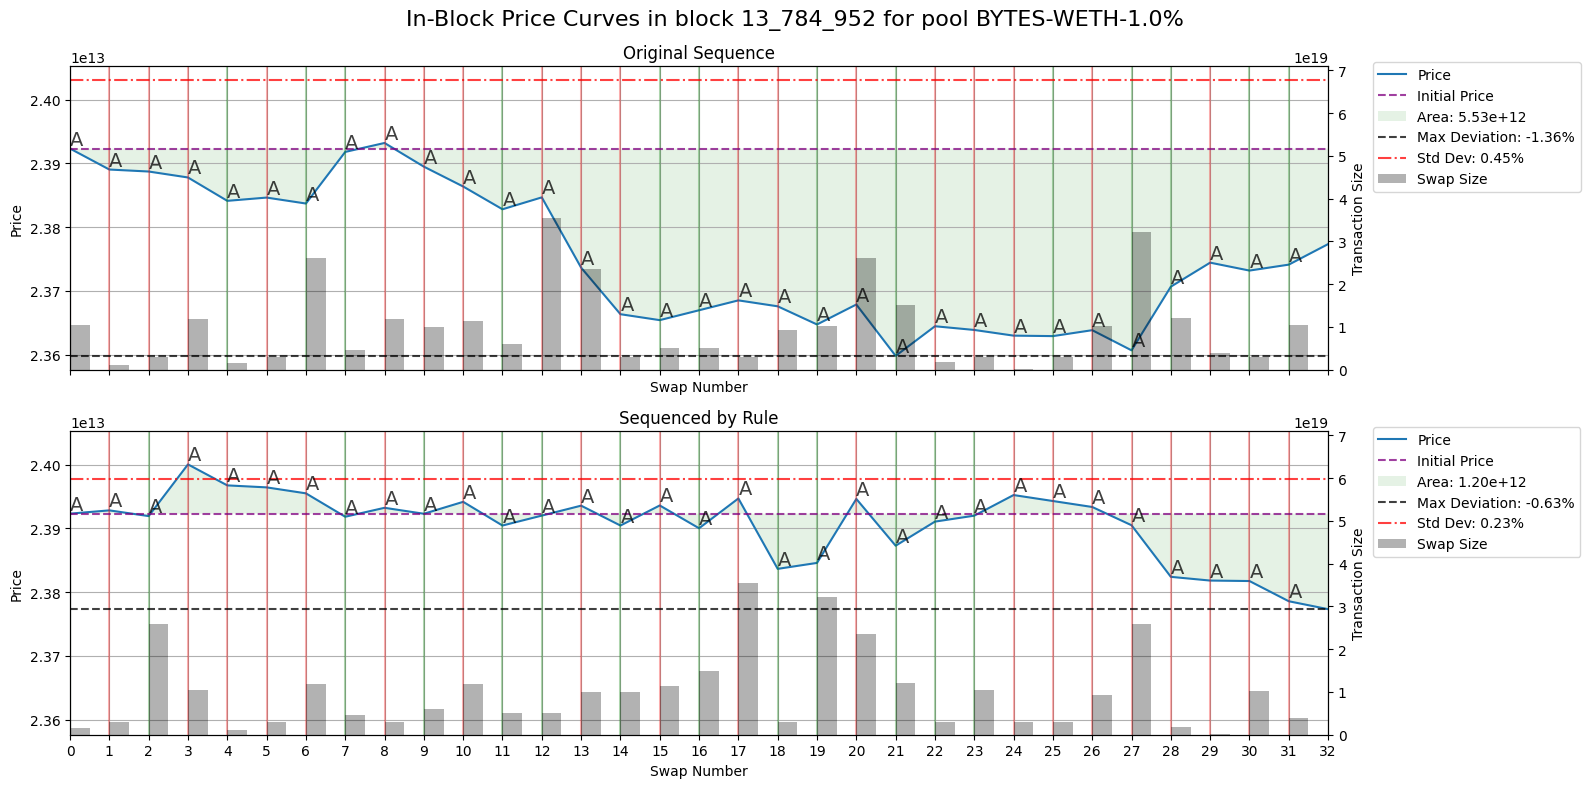

In [18]:
# Get a dataframe of blocks that has enough buys and sells
block_number = 13784952
address = "0x3782a3425cd093d5cd0c5b684be72641e199029c"

def run_comparison(block_number: int, address: str) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    df = block_of_swaps_in_pool(block_number, address)
    
    pool = load_pool(
        pool_address=address,
        postgres_uri=postgres_uri,
    )

    pool.name = pool_name(address, engine)

    original_prices, sequenced_prices, senders_dict = compare_with_sequencing_rule(df, pool)

    return original_prices, sequenced_prices, senders_dict


original_prices, sequenced_prices, senders_dict = run_comparison(block_number, address)

### Look at several examples

Loading pool from cache


0it [00:00, ?it/s]

Initializing liquidity


30it [00:00, 57.88it/s]
30it [00:00, 69.81it/s]


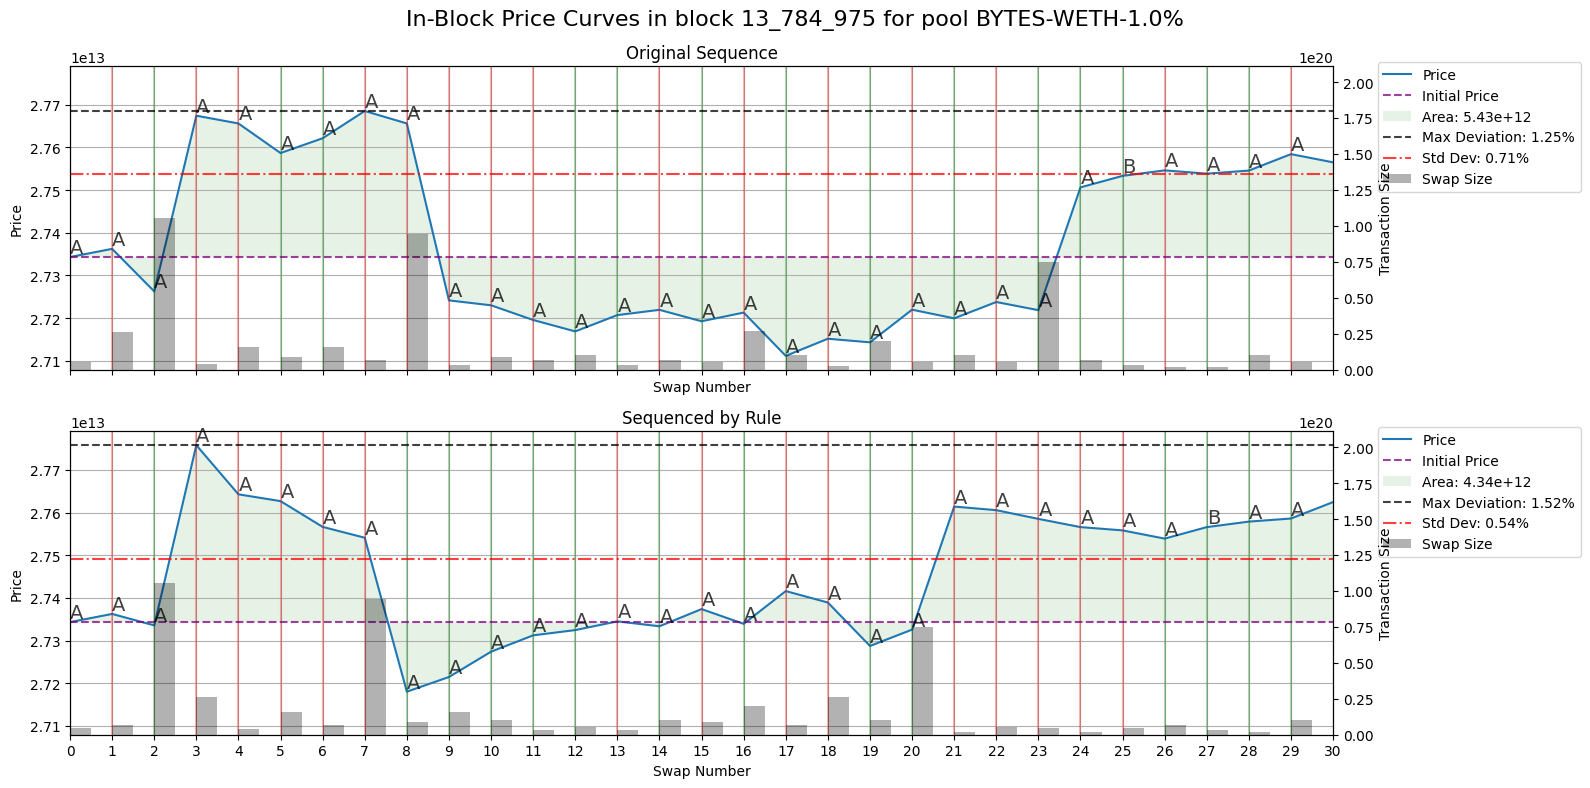

2it [00:00, 14.40it/s]

Initializing liquidity


30it [00:01, 22.84it/s]
30it [00:01, 23.20it/s]


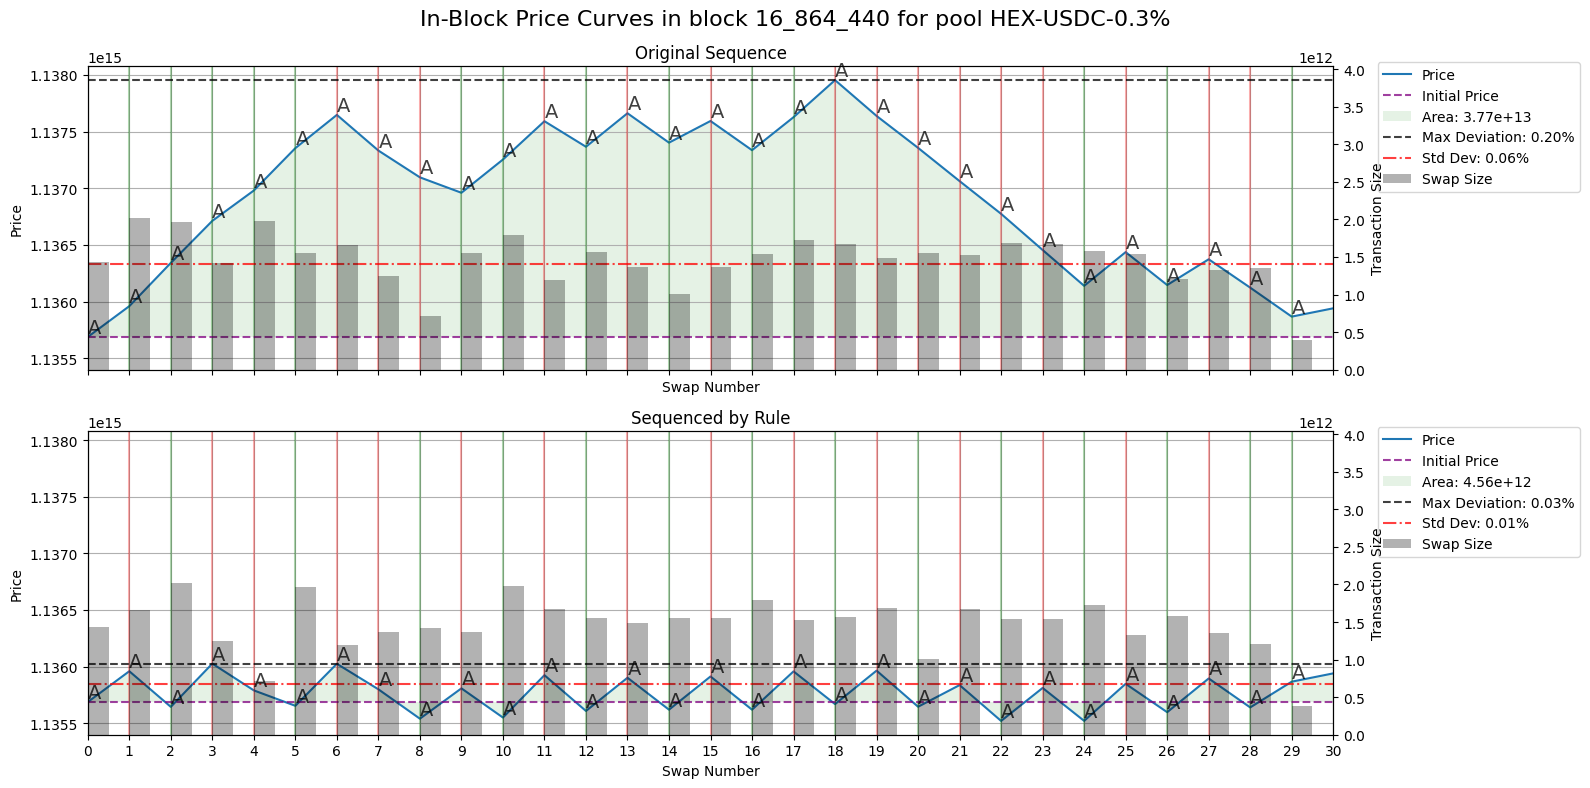

Loading pool from cache


0it [00:00, ?it/s]

Initializing liquidity


28it [00:00, 64.37it/s]
28it [00:00, 67.20it/s]


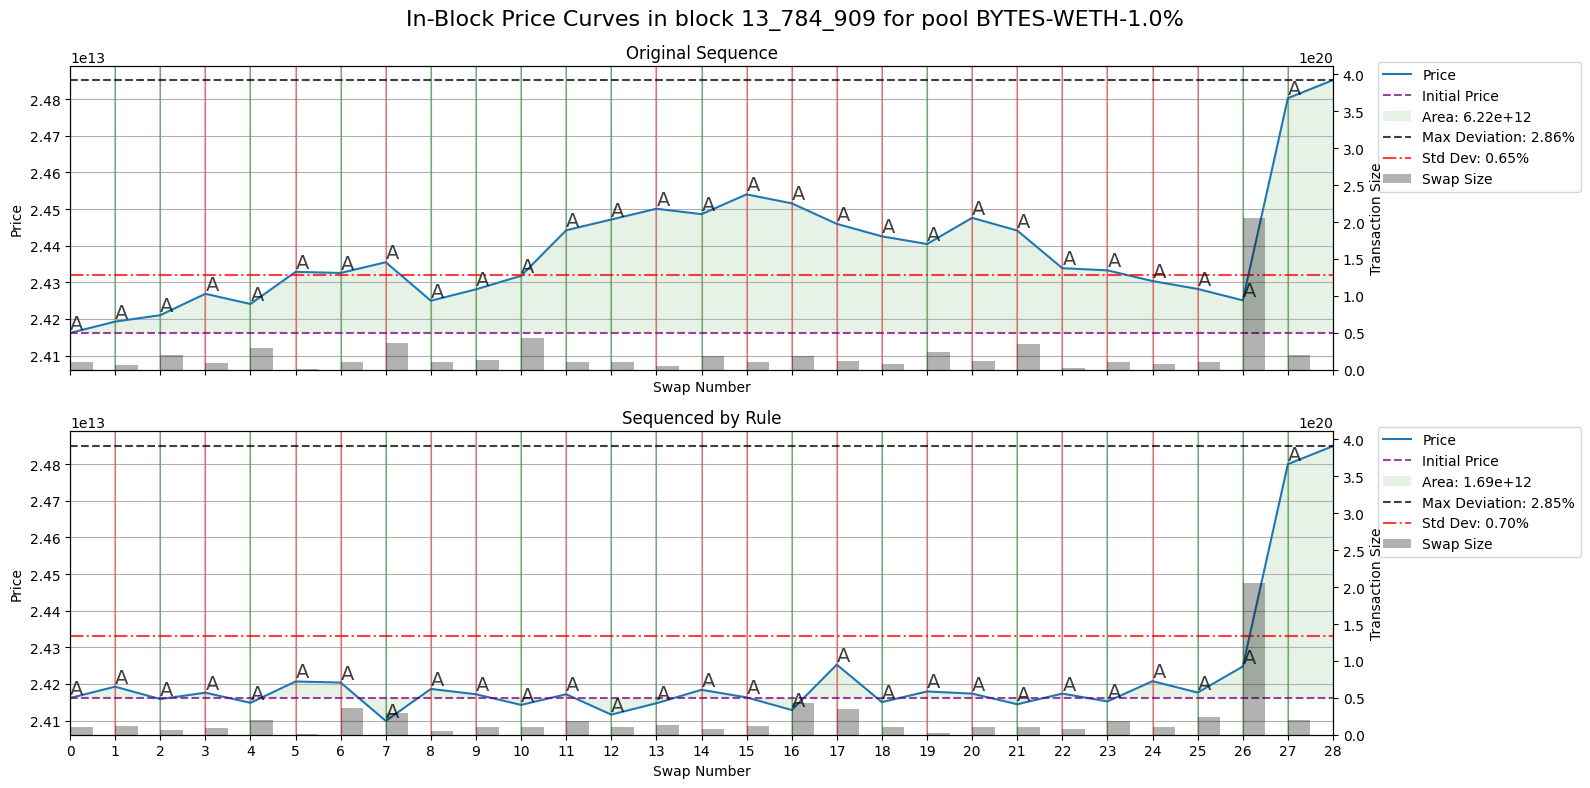

In [20]:
for block_number, pool_address in zip(swap_counts.block_number.iloc[:10], swap_counts.address.iloc[:10]):
    run_comparison(block_number, pool_address)
    plt.show()

## Calculate the difference in price for each swap

In [307]:
def get_welfare_change(original: pd.DataFrame, sequenced: pd.DataFrame) -> pd.DataFrame:
    diff_df = pd.concat(
        [
            original.rename(columns={"prices": "actual"}).drop(columns="direction"),
            sequenced.rename(columns={"prices": "sequenced"}),
        ],
        axis=1,
    )

    df_diff = diff_df.assign(directional_diff=np.where(df.direction.values == "sell", (diff_df.sequenced - diff_df.actual).values, diff_df.actual - diff_df.sequenced)) # type: ignore
    df_diff = df_diff.assign(relative_diff=df_diff.directional_diff / df_diff.actual) # type: ignore

    # Join with the senders from the original dataframe
    df_diff = df_diff.join(df.sender)
    df_diff.sender = df_diff.sender.map(senders_dict)

    return df_diff

df_diff = get_welfare_change(original_prices, sequenced_prices)

df_diff.head()

,,actual,sequenced,direction,directional_diff,relative_diff,sender
transaction_index,log_index,,,,,,
290,463,2.389037e+13,2.389549e+13,sell,5.127413e+09,0.000215,A
118,97,2.388725e+13,2.397344e+13,sell,8.618771e+10,0.003608,A
292,468,2.387791e+13,2.396408e+13,sell,8.617086e+10,0.003609,A
180,224,2.384125e+13,2.392735e+13,sell,8.610475e+10,0.003612,A
382,650,2.384637e+13,2.392838e+13,buy,-8.200767e+10,-0.003439,A


## Compare the welfare of the traders

/var/folders/wz/m18d0_fs3bn6b22tw0x4gsk00000gn/T/ipykernel_58710/3945527388.py:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(1.2*min(trader_diff['directional_diff']), 1.2*max(trader_diff['directional_diff']))  # add some padding above and below the max/min values


,directional_diff,relative_diff
sender,,
A,3.273144e+11,0.013918
Total,3.273144e+11,0.013918


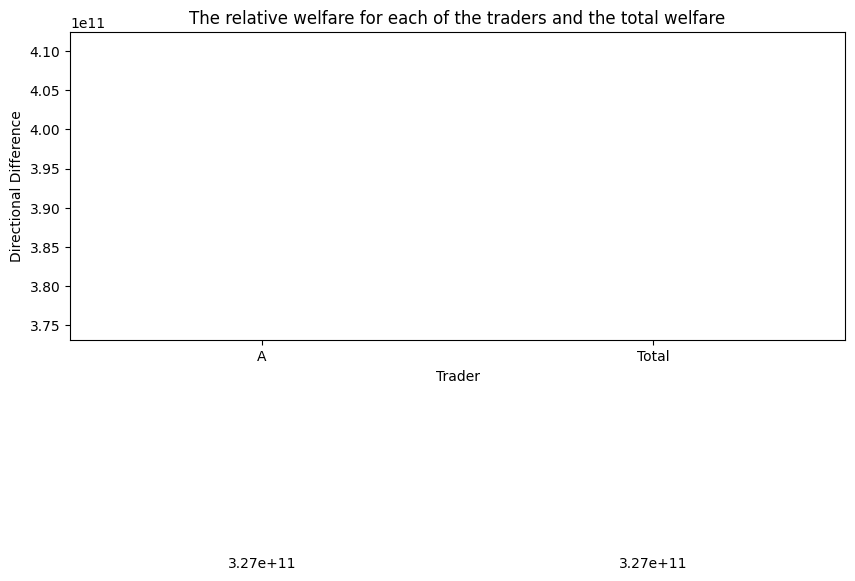

In [308]:
def plot_traders_welfare(df_diff: pd.DataFrame) -> pd.DataFrame:

    # Aggregate the difference by sender and add a total row
    trader_diff = df_diff.groupby("sender").agg(
        {
            "directional_diff": "sum",
            "relative_diff": "sum",
        }
    )

    trader_diff.loc["Total"] = trader_diff.sum()


    # create a color list, using green for positive values and red for negative
    colors = ['g' if (x > 0) else 'r' for x in trader_diff['directional_diff']]
    colors[-1] = 'gray'  # assuming 'Total' is the last row


    fig, ax = plt.subplots(figsize=(10, 4))

    # create the bar plot
    bars = ax.bar(trader_diff.index, trader_diff['directional_diff'], color=colors)

    # add data labels
    for bar in bars:
        yval = bar.get_height()
        yval_sci = f"{yval:.2e}"

        if yval > 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, yval_sci, ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, yval_sci, ha='center', va='top')

    ax.set_ylim(1.2*min(trader_diff['directional_diff']), 1.2*max(trader_diff['directional_diff']))  # add some padding above and below the max/min values

    # add title and labels
    plt.title('The relative welfare for each of the traders and the total welfare')
    plt.xlabel('Trader')
    plt.ylabel('Directional Difference')

    return trader_diff

trader_diff = plot_traders_welfare(df_diff)

trader_diff.head()